In [1]:
import warnings

from functools import partial
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from statsmodels.tsa.stattools import acf

from neurodsp.sim import sim_poisson_pop, sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_poisson_distribution, sim_spikes_synaptic
from timescales.acf import exp_decay_func

## Parameters

This notebook explores the affect of parameters on the accuracy of fitting different taus. The three parameters of interest are:

1. tau : simulated timescale
2. n_neurons : number of neurons to simulate
3. mu : the mean inter spike interval of the exponential distribution

In [2]:
def run_grid(params, fs=None):
    
    tau, n_seconds, mu = params
    
    # Simulate
    spikes = sim_spikes_synaptic(n_seconds, fs, tau, 200, mu, return_sum=False)
    
    # Compute acf
    for spike in spikes:
        corrs = acf(spike, nlags=fs, qstat=False, fft=True)[1:]
    
    
    corrs_true = np.exp(-np.arange(len(corrs) + 1) / (fs * tau))[1:]
    
    # Fit acf
    guess = [np.max(corrs), tau*fs, 0.]  

    bounds = [
        (0, 0, -2),
        (2*np.max(corrs), 200, 2)
    ]

    params, _ = curve_fit(exp_decay_func, np.arange(0, len(corrs)), corrs,
                          p0=guess, bounds=bounds, maxfev=1000)

    taus_hat = params[1] / fs
    
    return corrs, corrs_true, params, taus_hat


In [3]:
fs = 1000

# Define param grid
taus = np.linspace(.001, .1, 5)

#n_neurons = [250, 500, 750, 1000]
n_seconds = [250, 500, 750, 1000]
mus = [250, 500, 750, 1000]

params = []

for ns in n_seconds:
    for tau in taus:
        for n in mus:
                params.append([ns, tau, n])

In [4]:
n_jobs = cpu_count()

with Pool(processes=n_jobs) as pool:

    mapping = pool.imap(partial(run_grid, fs=fs), params)

    results = list(tqdm(mapping, total=len(params)))
    
autocorrs = np.array([result[0] for result in results])
autocorrs_true = np.array([result[1] for result in results])
fit_params = np.array([result[2] for result in results])
taus_acf = np.array([result[3] for result in results])

  0%|          | 0/80 [00:00<?, ?it/s]

### Bias

Below, the ground exponential decay (blue) is plotted against the simulated autocorrelation (orange), in semilog space. The bias here is due to finite duration simulations - the simulated autocorrelation should approach ground truth as the duration increases.

It would be intersting to similarily compare ground truth spectra to simulated spectra, however, it's unclear how to determine what the ground truth exponent and offset would be for a given simulation.

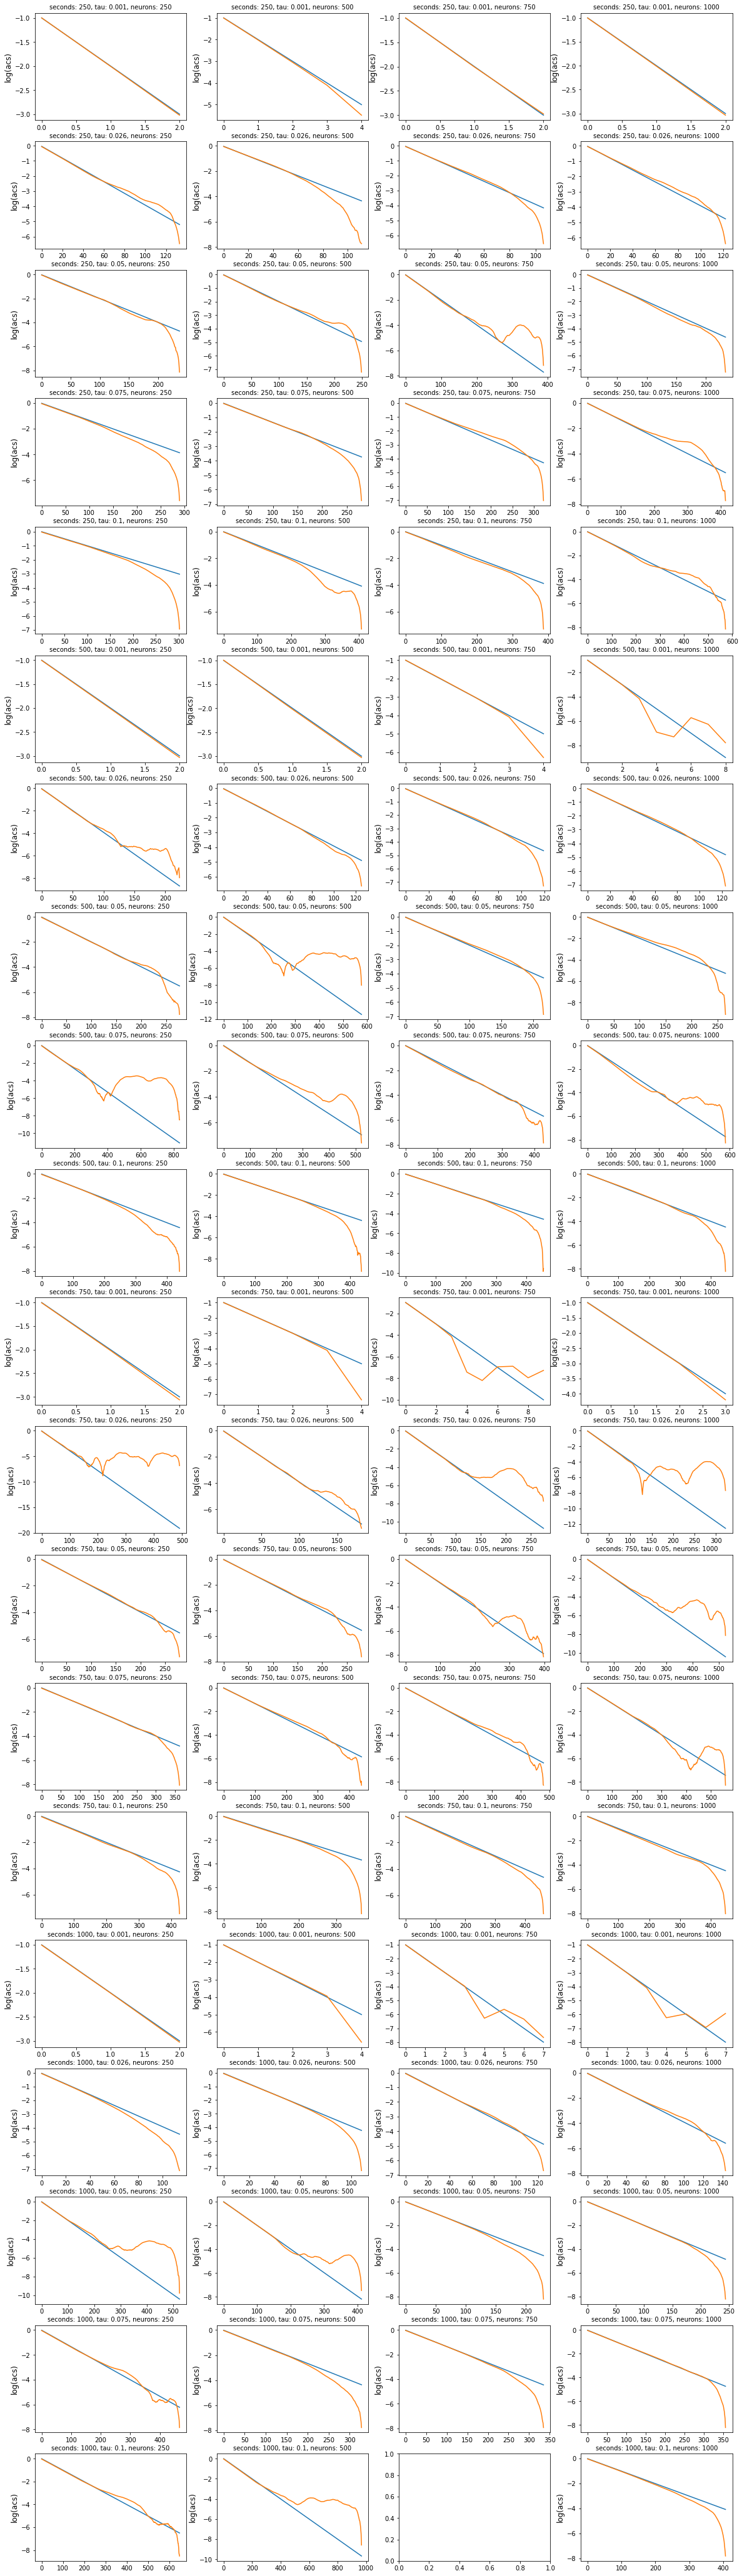

In [6]:
fig, axes = plt.subplots(figsize=(20, 75), nrows=20, ncols=4)
ax_inds = [(i, j) for i in np.arange(20) for j in np.arange(4)]

for ind, (ac, ac_true) in enumerate(zip(autocorrs, autocorrs_true)):
    if len(np.where(ac <= 0)[0]) == 0:
        continue
    ax = axes[ax_inds[ind]]
    
    lags = np.arange(len(ac))
    last_ind = int(np.where(ac <= 0)[0].min()) - 1
    
    ax.plot(lags[:last_ind], np.log(ac_true[:last_ind]))
    ax.plot(lags[:last_ind], np.log(ac[:last_ind]))
    #ax.set_xlabel('Lags', size=12)
    ax.set_ylabel('log(acs)', size=12)
    
    _ns = params[ind][0]
    _tau = round(params[ind][1], 3)
    _neurons = params[ind][2]
    #_mu = params[ind][3]
    
    ax.set_title(f'seconds: {_ns}, tau: {_tau}, neurons: {_neurons}', size=10)

### Results

Error tends to increase as tau increases. The error also decreases as n_seconds increases.

In [7]:
df = pd.DataFrame()

df['Tau Sim'] = [param[1] for param in params]
df['Tau ACF'] = taus_acf

# Error
mae = np.zeros(len(autocorrs))

for ind, (ac, ac_true) in enumerate(zip(autocorrs, autocorrs_true)):
    mae[ind] = np.mean(np.abs(ac - ac_true))
    
df['Error'] = mae

df['n_seconds'] = [param[0] for param in params]
#df['n_neurons'] = [param[2] for param in params]
df['mu'] = [param[2] for param in params]

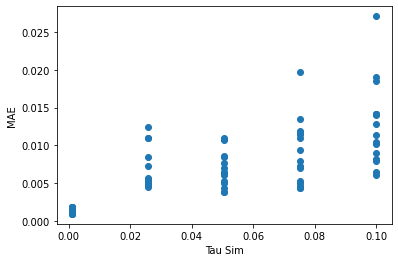

In [8]:
plt.scatter(df['Tau Sim'], df['Error'])
plt.xlabel('Tau Sim')
plt.ylabel('MAE');

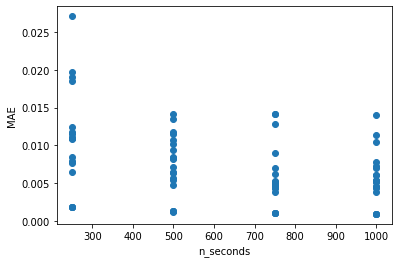

In [9]:
plt.scatter(df['n_seconds'], df['Error'])
plt.xlabel('n_seconds')
plt.ylabel('MAE');

In [ ]:
# Ran perviously to show n_neurons doesn't effect fit
#plt.scatter(df['n_neurons'], df['Error'])
#plt.xlabel('n_neurons')
#plt.ylabel('MAE');

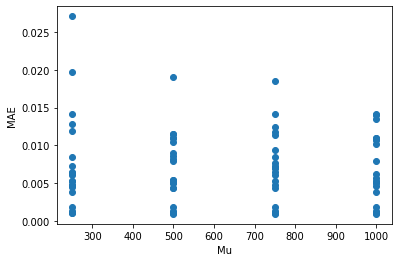

In [10]:
plt.scatter(df['mu'], df['Error'])
plt.xlabel('Mu')
plt.ylabel('MAE');

<IPython.core.display.Javascript object>


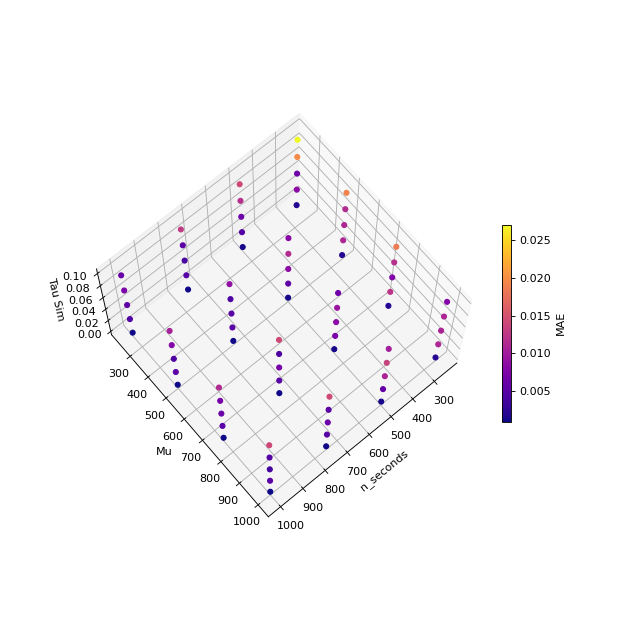

In [11]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection='3d')

# 3d scatter
p = ax.scatter3D(
    df['n_seconds'],
    df['mu'],
    df['Tau Sim'],
    c=df['Error'],
    cmap='plasma',
    depthshade=0
)

ax.set_xlabel('n_seconds')
ax.set_ylabel('Mu')
ax.set_zlabel('Tau Sim')

fig.colorbar(p, shrink=0.4, label='MAE')
plt.show()

<IPython.core.display.Javascript object>


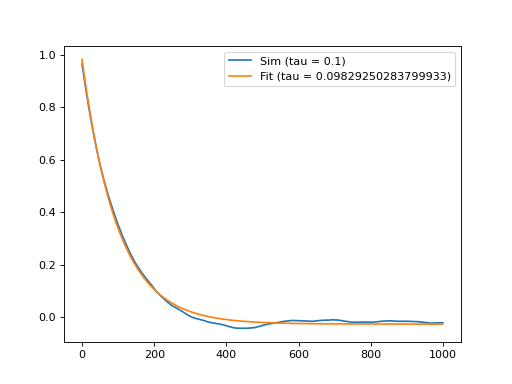

<IPython.core.display.Javascript object>


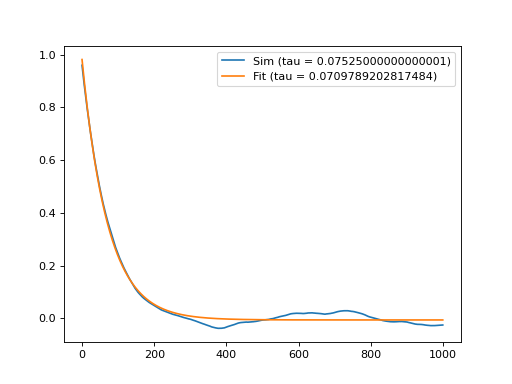

<IPython.core.display.Javascript object>


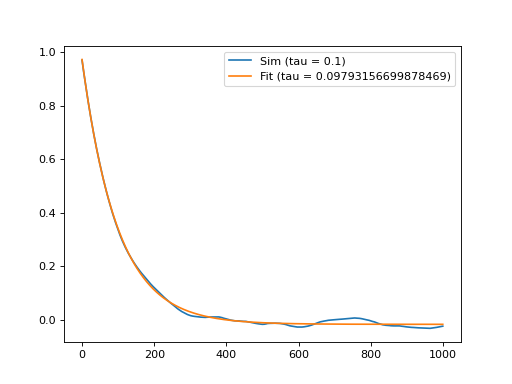

In [12]:
# Plot the worst tau estimation fits
lowest_inds = np.argsort(df['Error'].values)[::-1][:3]

for idx, ind in enumerate(lowest_inds):

    acf_sim = autocorrs[ind]
    acf_fit = exp_decay_func(np.arange(0, len(acf_sim)), *fit_params[ind])
    plt.figure(idx)
    plt.plot(acf_sim, label='Sim (tau = {x})'.format(x=df.iloc[ind]['Tau Sim']))
    plt.plot(acf_fit, label='Fit (tau = {x})'.format(x=df.iloc[ind]['Tau ACF']))
    plt.legend()

### Manuscript Figures

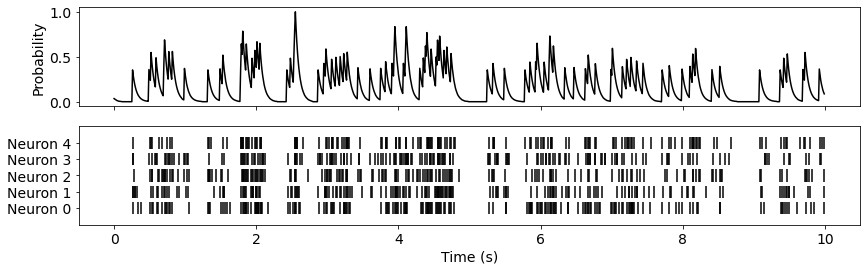

In [2]:
from matplotlib import rc

tau = 0.05
fs = 100
mu = 1000
n_seconds = 10
kernel = sim_synaptic_kernel(5 * tau, fs, 0, tau)


# Sim probabiltiies
times = np.arange(0, int(n_seconds + (len(kernel) * 2)), 1/fs)
probs = sim_poisson_distribution(n_seconds, fs, kernel)


# Sim spikes
n_neurons = 5

spikes = np.zeros((n_neurons, len(probs)), dtype=bool)

for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))
    
    
# Plot
font = {'size'   : 14}
rc('font', **font)


fig, axes = plt.subplots(nrows=2, figsize=(14, 4), sharex=True)

times = np.arange(0, n_seconds, 1/fs)
axes[0].plot(times, probs, color='k')
axes[0].set_ylabel('Probability')
axes[1].eventplot([times[s] for s in spikes], color='k', linelengths=.75)  
axes[1].set_yticks(np.arange(len(spikes)))
axes[1].set_yticklabels([f'Neuron {i}' for i in range(5)]);
axes[1].set_xlabel('Time (s)');

#plt.savefig("/home/rph/Pictures/probs", dpi=500)

  0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_21874/747541595.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  autocorrs = np.array([result[0] for result in results])
/tmp/ipykernel_21874/747541595.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  autocorrs_true = np.array([result[1] for result in results])


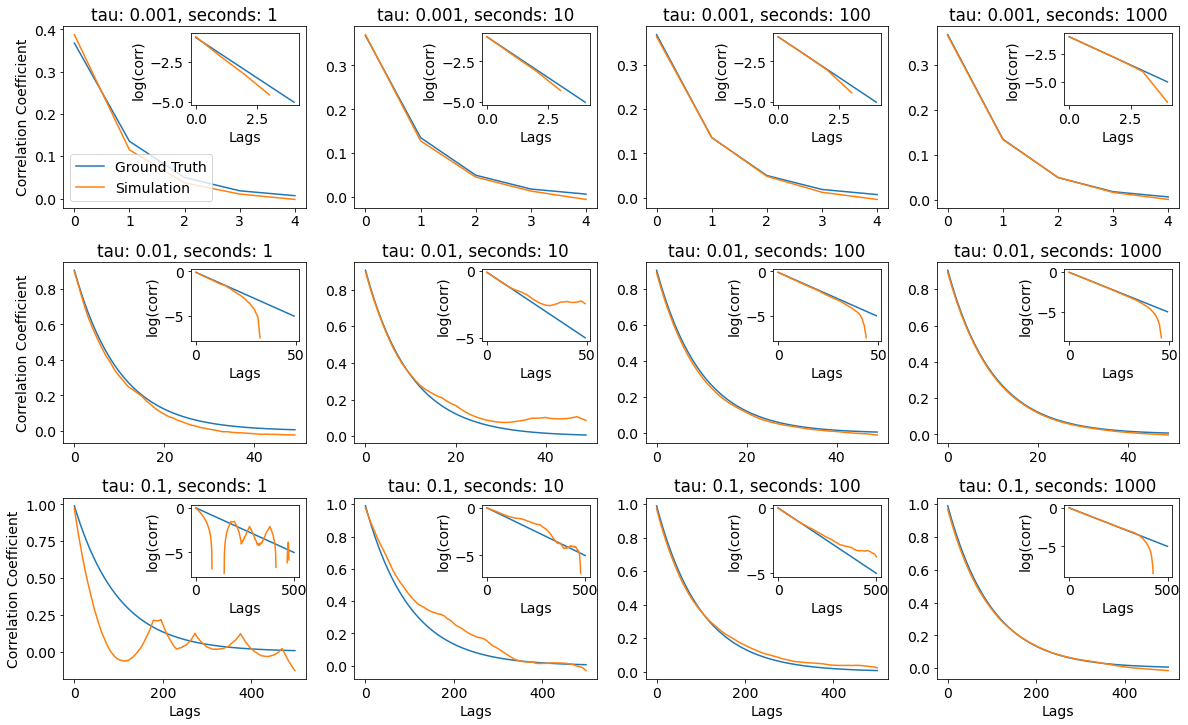

In [3]:
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fs = 1000

def run_grid(params, fs=None):
    
    tau, n_seconds, mu = params
    
    # Simulate
    spikes = sim_spikes_synaptic(n_seconds, fs, tau, 200, mu, return_sum=True)
    
    # Compute acf
    corrs = acf(spikes, nlags=fs, qstat=False, fft=True)[1:]
    corrs_true = np.exp(-np.arange(len(corrs) + 1) / (fs * tau))[1:]
    
    # Fit acf
    guess = [np.max(corrs), tau*fs, 0.]  

    bounds = [
        (0, 0, -2),
        (2*np.max(corrs), 200, 2)
    ]

    params, _ = curve_fit(exp_decay_func, np.arange(0, len(corrs)), corrs,
                          p0=guess, bounds=bounds, maxfev=1000)

    taus_hat = params[1] / fs
    
    return corrs, corrs_true, params, taus_hat


# Re-define param grid
taus = np.array([.001, .01, .1])
n_seconds = [1, 10, 100, 1000]
mus = [500]

params = []

for tau in taus:
    for ns in n_seconds:
        for n in mus:
            params.append([tau, ns, n])
            

# Run Grid
n_jobs = cpu_count()

with Pool(processes=n_jobs) as pool:

    mapping = pool.imap(partial(run_grid, fs=fs), params)

    results = list(tqdm(mapping, total=len(params)))
    
autocorrs = np.array([result[0] for result in results])
autocorrs_true = np.array([result[1] for result in results])
fit_params = np.array([result[2] for result in results])
taus_acf = np.array([result[3] for result in results])


# Plotting
fig, axes = plt.subplots(figsize=(20, 12), nrows=3, ncols=4)
fig.subplots_adjust(hspace=.3)
ax_inds = [(i, j) for i in np.arange(20) for j in np.arange(4)]

for ind, (ac, ac_true) in enumerate(zip(autocorrs, autocorrs_true)):

    
    ax = axes[ax_inds[ind]]
    _tau = round(params[ind][0], 3)
    _ns = params[ind][1]
    _mu = params[ind][2]
    
    
    lags = np.arange(len(ac))
    last_ind = int(5 * _tau * fs)
    
    ax.plot(lags[:last_ind], ac_true[:last_ind], label='Ground Truth')
    ax.plot(lags[:last_ind], ac[:last_ind], label='Simulation')
    
    
    ax.set_title(f'tau: {_tau}, seconds: {_ns}')
    
    if ind == 0:
        ax.legend(loc='lower left')
        
    if ind in [0, 4, 8]:
        ax.set_ylabel('Correlation Coefficient')
        
    if ind in [8, 9, 10, 11]:
        ax.set_xlabel('Lags')
        
    axins = inset_axes(ax, width=1.5, height=1)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        axins.plot(lags[:last_ind], np.log(ac_true[:last_ind]))
        axins.plot(lags[:last_ind], np.log(ac[:last_ind]))
        axins.set_ylabel('log(corr)')
        axins.set_xlabel('Lags')

#plt.savefig("/home/rph/Pictures/sim_error", dpi=500)